[Reference](https://medium.com/bip-xtech/conformal-prediction-for-forecast-confidence-intervals-427887aa8f14)

In [2]:
pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from statsforecast.utils import ConformalIntervals

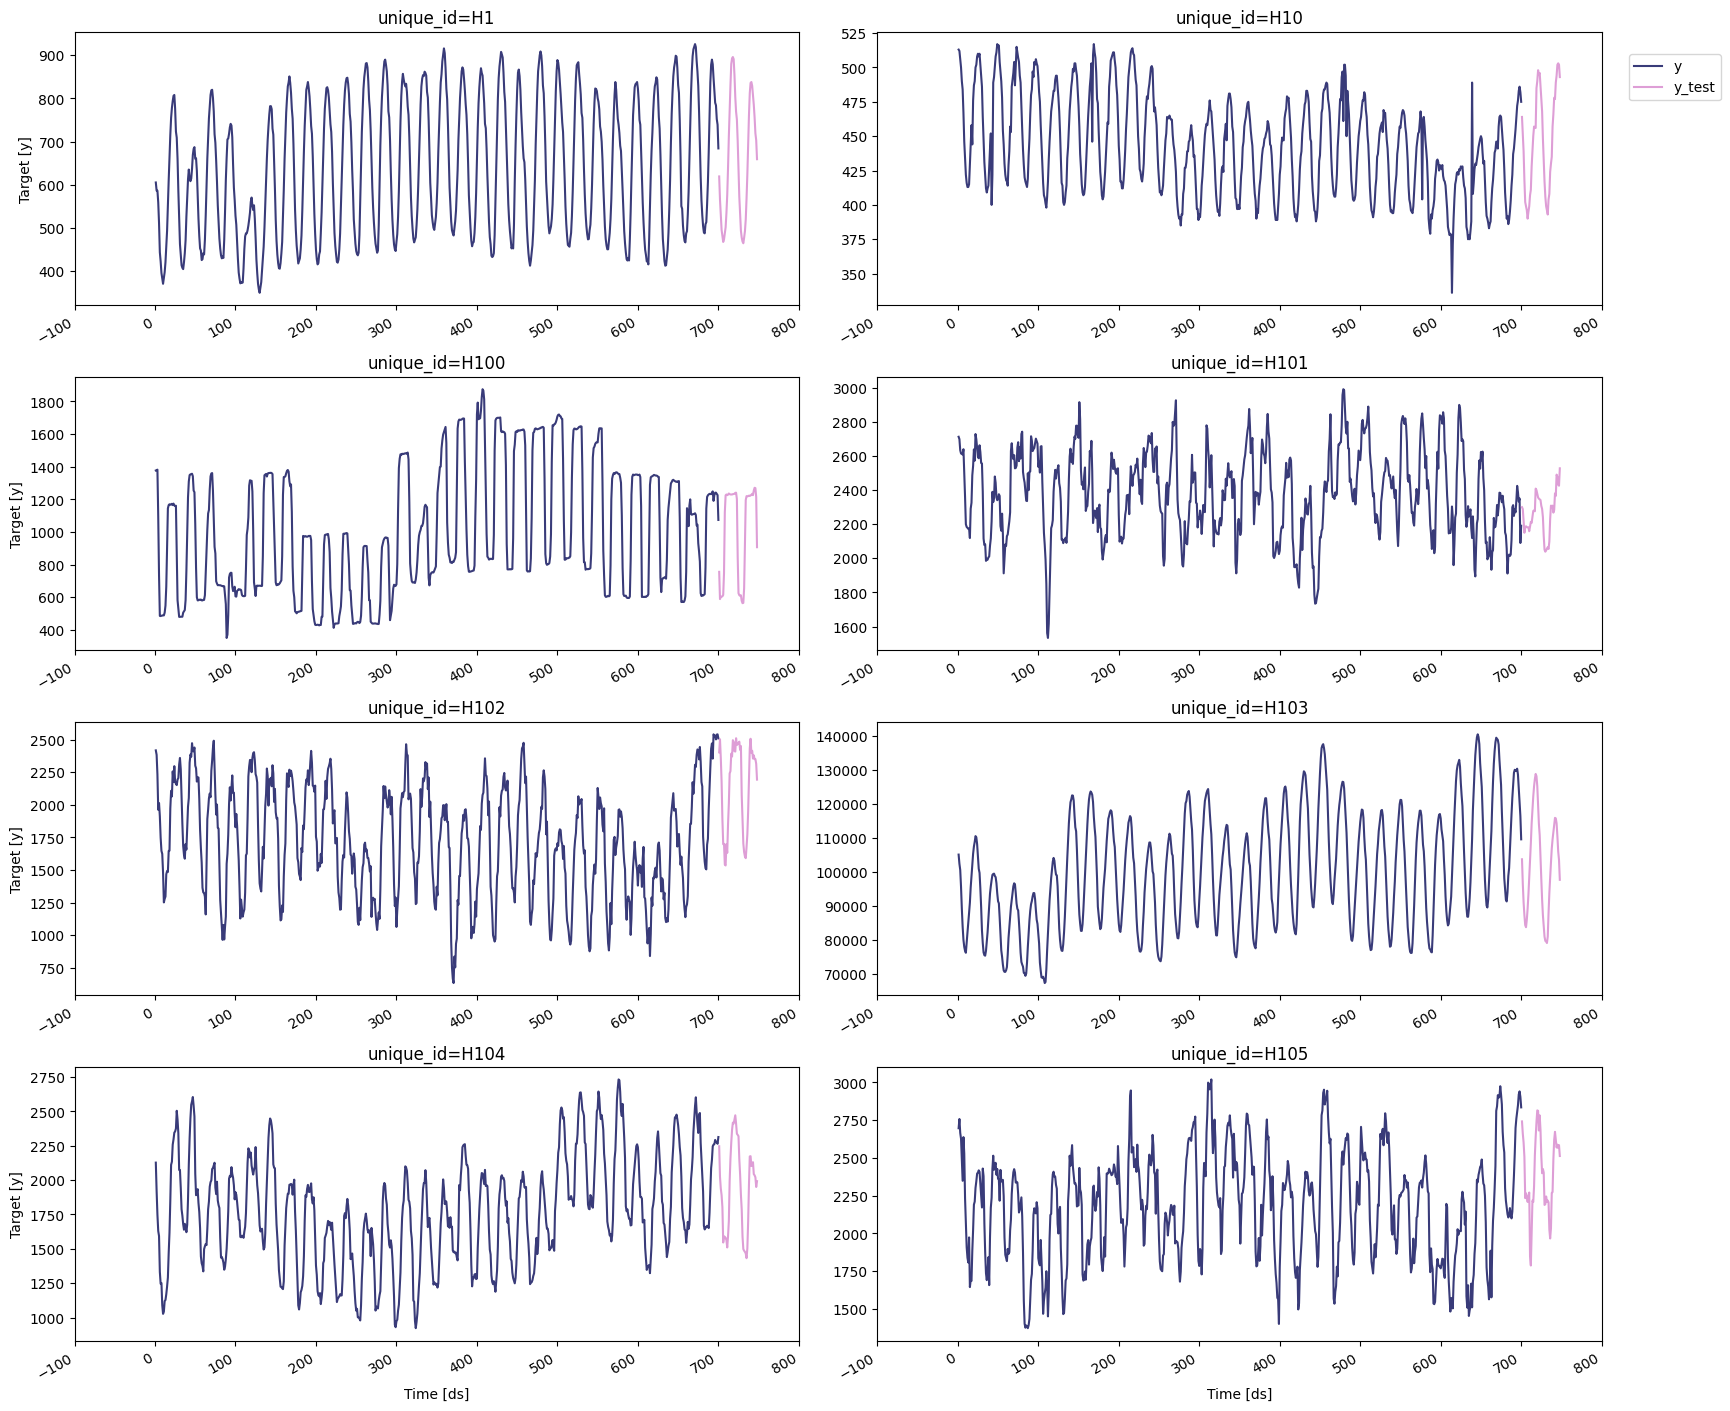

In [4]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})
n_series = 8
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

StatsForecast.plot(train, test, plot_random = False) # plot the time series

In [5]:
models = [SeasonalNaive(25)]
sf = StatsForecast(
    models=models,
    freq=1,
    n_jobs=-1)

In [6]:
levels = [80] # confidence levels of the prediction intervals
forecasts = sf.forecast(df=train, h=48, level=levels)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
plot_test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])
train_test = pd.concat([train, test.rename(columns={'y_test':'y'})])
sf.plot(train_test, plot_test, plot_random = False, models=['SeasonalNaive'], level=levels, engine='plotly', max_insample_length=100)

In [8]:
((plot_test['SeasonalNaive-lo-80']<=plot_test['y_test']) & (plot_test['y_test']<=plot_test['SeasonalNaive-hi-80'])).mean()
plot_test.groupby('unique_id').apply(lambda x:x['SeasonalNaive-hi-80']-x['SeasonalNaive-lo-80']).groupby('unique_id').mean()

unique_id
H1        265.139740
H10        64.853813
H100      890.339600
H101      977.900391
H102     1066.100586
H103    30016.218750
H104      903.897644
H105     1095.103882
dtype: float32

In [9]:
models = [
    SeasonalNaive(25,
    prediction_intervals=ConformalIntervals(h=48, n_windows=30))
]